# **DATA 100 Final Project**

## **Authors: Kathy Wu, Yewen Zhou**

## **Topic: COVID-19**

## **Questions to address**: <br> 


Below are the questions that we are trying to address in this project. Due to the limitations of the space, we will only include the main part of this project - the first two - in our final report. We will leave the rest 3 in this notebook as a reference of our efforts to address other interesting questions. 

**1, Are the confirmed cases still growing? Is it growing faster or slower?** <br>
**2, How effective is social distancing?** <br> 
3, What are some factors that are correlated to the mortality rate? <br>
4, How is the trend changing overtime in California?

## **Import all necessary modules**

In [0]:
# import necessary modules 
import pandas as pd
import pandas.util.testing as tm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline
import plotly.express as px


## **Load data sets**

The following cell will mount the drive so that it's easier to upload the data sets. 

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
# read csv files as DataFrames 
states = pd.read_csv("drive/My Drive/Colab Notebooks/05-03-2020.csv")
states.head(3)

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-05-04 02:32:32,32.3182,-86.9023,7888,290,0,7598.0,1,168.227197,92500.0,1035.0,3.676471,84000001,USA,1972.745403,13.121197
1,Alaska,US,2020-05-04 02:32:32,61.3707,-152.4044,368,9,262,97.0,2,61.564302,21578.0,NaN,2.445652,84000002,USA,3609.876386,NaN
2,American Samoa,US,2020-05-04 02:32:32,-14.2710,-170.1320,0,0,0,0.0,60,0.000000,57.0,NaN,NaN,16,ASM,102.442444,NaN


In [67]:
abridged_counties = pd.read_csv("drive/My Drive/Colab Notebooks/abridged_couties.csv")
abridged_counties.head(3)

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,...,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,01001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,South,East South Central,2.0,55601.0,27007.0,28497.0,0.486578,8392.0,91.8,54571.0,37.0,11439.0,8046.0,16.0,9.9,204.5,56.1,18.081557,81.79,324.0,50.0,0.0,1.0,6.0,0.326656,1866.0,1713.0,2001.0,1990.0,2171.0,...,1594.0,1736.0,3978.0,4265.0,4040.0,4165.0,1524.0,1559.0,1279.0,1498.0,1821.0,2192.0,841.0,1141.0,159.0,392.0,NaN,NaN,NaN,NaN,10.0,20.0,44.0,73.0,112.0,143.0,109.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,01003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,South,East South Central,3.0,218022.0,103225.0,109403.0,0.485472,42413.0,114.7,182265.0,41.1,54145.0,41590.0,33.0,8.5,183.2,41.9,17.489033,54.28,2101.0,536.0,0.0,3.0,51.0,0.253255,5614.0,5544.0,5832.0,5767.0,6076.0,...,5317.0,5392.0,11620.0,11933.0,13047.0,13874.0,5943.0,6580.0,5728.0,6284.0,8558.0,9245.0,4379.0,5153.0,1176.0,2057.0,13.0,NaN,NaN,23.0,30.0,52.0,125.0,262.0,434.0,546.0,597.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,01005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,South,East South Central,6.0,24881.0,13335.0,11935.0,0.527701,4757.0,31.0,27457.0,39.0,6681.0,4706.0,NaN,15.7,220.4,49.0,21.999985,69.82,181.0,12.0,0.0,1.0,5.0,0.893106,847.0,855.0,826.0,816.0,820.0,...,1162.0,646.0,2115.0,1513.0,2164.0,1854.0,910.0,907.0,859.0,940.0,1067.0,1171.0,498.0,730.0,129.0,314.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,44.0,65.0,72.0,68.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0


In [68]:
confirmed = pd.read_csv("drive/My Drive/Colab Notebooks/time_series_covid19_confirmed_US.csv")
confirmed.head(3)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20
0,16.0,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,"American Samoa, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316.0,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,"Guam, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,37,45,51,55,56,58,69,77,82,84,93,112,113,121,121,128,130,133,133,133,133,135,135,136,136,136,136,136,136,139,141,141,141,141,141,141,145,145,145,145
2,580.0,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,"Northern Mariana Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,6,6,8,8,8,8,8,11,11,11,11,11,11,11,13,13,13,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14


In [69]:
deaths = pd.read_csv("drive/My Drive/Colab Notebooks/time_series_covid19_deaths_US.csv")
deaths.head(3)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20
0,16.0,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,"American Samoa, US",55641,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316.0,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,"Guam, US",164229,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,2,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
2,580.0,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,"Northern Mariana Islands, US",55144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


## **Introduce all possible functions and models**

In [0]:
# takes number of days as input and returns the Date
def get_date(day):
  start = pd.Timestamp('2020-01-22')
  end = start + pd.Timedelta(days = day)
  return end


In [0]:
def get_days(date):
  start = pd.Timestamp('2020-01-22')
  # convert date string to datetime 
  date = pd.to_datetime(date)
  return (date - start).days

## **Q1: Are the confirmed cases still growing? How fast?**


In [0]:
import statsmodels.api as sm

In [0]:
# define a function that returns a dataframe from the "confirmed" dataframe with the specific state 
# in the past x days 
# STATE should be string and x should be an integer
def get_df(state, x):
  # get the sume of all confirmed cases 
  df = confirmed[confirmed["Province_State"] == state].sum()
  # convert the series to dataframe 
  df = df[11:].to_frame()
  # add a column of Days after 1/22/20
  date = pd.Timestamp('2020-01-22')
  df["Days"] = (pd.to_datetime(df.index) - date).days
  # rename the column
  df = df.rename(columns = {0 : "Cases"})
  # add another column of growth rate 
  df["Growth Rate"] = df["Cases"].pct_change()
  # select only the past x days 
  df = df.iloc[df.shape[0] - x:, :]
  # add another column starting from the past 0th day 
  df["Count Up"] = (pd.to_datetime(df.index) - pd.to_datetime(df.index[0])).days
  # add a log scale 
  df["log"] = np.log(df["Cases"].astype(float))
  # return the dataframe 
  return df 

In [0]:
# fit a linear regression model with x being the "Count Up" and y 
# being growth rate
# plots the regression line and residuals 
# evaluates the model
def fit_linear_model(state, x):
  # get the dataframe of the specific state 
  df = get_df(state, x)
  # fit linear regression model 
  X = df[["Count Up"]]
  Y = df["Growth Rate"]
  X = sm.add_constant(X)
  model = sm.OLS(Y, X).fit()
  print(model.summary())
  # make the plots
  plt.plot(df["Growth Rate"], linestyle = '--', marker = 'o', label = "Growth Rate in confirmed cases")
  plt.xticks(rotation = 45)
  plt.xlabel("Date")
  plt.ylabel("Growth Rate")
  plt.title("Growth Rate of confirmed cases in the past " + str(x) + " days in " + state)
  params = model.params.to_list()
  x_val = df["Count Up"]
  y1 = params[1] * x_val + params[0]
  # add a column of residues 
  df["Residual"] = df["Growth Rate"] - y1
  plt.plot(x_val, y1)
  plt.show()
  # plot the residual plot
  plt.scatter(df.index, df["Residual"])
  y2 = 0 * x_val
  plt.plot(x_val, y2, linestyle = '--', color = 'red')
  plt.xticks(rotation = 45)
  plt.xlabel("Date")
  plt.ylabel("Residual")
  plt.title("Residual of the Growth Rate in the past " + str(x) + " days in " + state)
  plt.show()
  # print on which date the predicted growth rate reaches 0
  start_date = pd.to_datetime(df.index[0])
  inflection_pt = int(-params[0] / params[1])
  if inflection_pt > 0:
    predicted_date = start_date + pd.Timedelta(days = inflection_pt)
    print("The peak time will come on " + predicted_date.strftime("%Y-%m-%d"))
  else:
    print("The growth rate is still increasing")

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

def fit_evaluate(state, x):
  # get the dataframe 
  df = get_df(state, x)
  # x and y values
  X = df[["Count Up"]]
  y = df["Growth Rate"]
  # initialize a linear regression model 
  model = LinearRegression()
  # fit the model 
  model.fit(X, y)
  # the coef and intercept 
  coef = model.coef_
  intercept = model.intercept_
  # make the plot of the original data
  plt.plot(df["Growth Rate"], linestyle = "--", marker = "o", label = "Original")
  # make the plot of the regression model 
  x_val = df["Count Up"]
  y = coef * x_val + intercept 
  plt.plot(x_val, y, linestyle = '--', marker = 'o', label = "Linear Regression")
  plt.legend()
  plt.ylabel("Growth Rate")
  plt.title("Growth Rate in " + state + " in the past " + str(x) + " days")
  plt.show()
  # evaluate the model 
  score = cross_val_score(model, X, y, cv = 3)
  print("The cross-validation scores are: ", score)

In [0]:
# get a slice of the DF from SRART date to END date. 
# df should take on the form that is consistent with get_df()
# start and end are inclusive
# start and end should both be strings
def get_slice(df, start, end):
  start_index = get_days(start)
  end_index = get_days(end)
  return df.iloc[start_index : end_index + 1, :]

                            OLS Regression Results                            
Dep. Variable:            Growth Rate   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                 -0.143
Method:                 Least Squares   F-statistic:                    0.2492
Date:                Sat, 09 May 2020   Prob (F-statistic):              0.639
Time:                        01:46:06   Log-Likelihood:                 22.566
No. Observations:                   7   AIC:                            -41.13
Df Residuals:                       5   BIC:                            -41.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0369      0.008      4.751      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning:

omni_normtest is not valid with less than 8 observations; 7 samples were given.



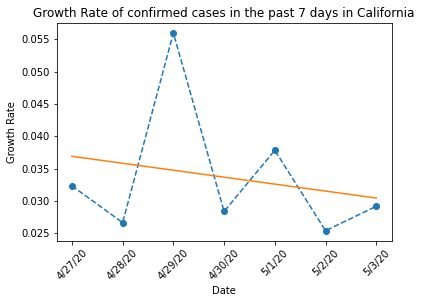

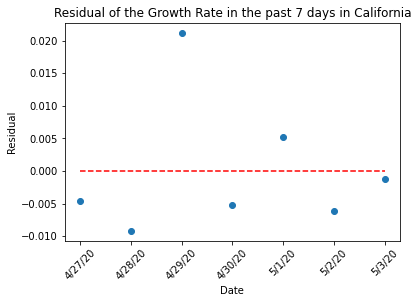

The peak time will come on 2020-05-31


In [77]:
fit_linear_model("California", 7)

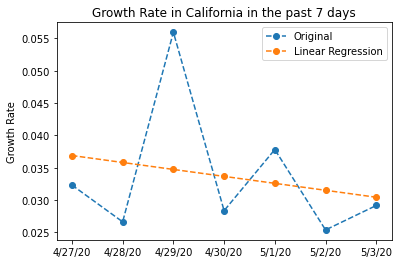

The cross-validation scores are:  [1. 1. 1.]


In [78]:
# evaluate the model
fit_evaluate("California", 7)

In the following cell, try fitting a multilinear regression model with x_train being the growth rates in the past x days and y_train being the growth rate on 5/3/20. 

In [0]:
# fit a multi-linear regression model based on the growth rate in the past x days 
# the reponse variable is the growth rate on 5/3/20
# the covariates the growth rate x days before 5/3/20 
# instead of using "Days" as the single feature 
def fit_multi_linear_model(state, x):
  # get the dataframe 
  df = get_df(state, x + 1)
  # take the transpose of the dataframe 
  df = df.T
  # select only rows of "Count Up" and "Growth Rate"
  df = df.loc[["Growth Rate"], :]
  X = df.iloc[:, 0:x]
  y = df.iloc[:, x]
  # display the dataframe 
  display(X)
  # fit a multi-linear regression model 
  model = LinearRegression()
  model.fit(X, y)
  # evaluate the score 
  score = model.score(X, y)
  print("The accuracy score is: ", score)
  

In [80]:
fit_multi_linear_model("California", 7)

,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20
Growth Rate,0.0280872,0.0323247,0.0266424,0.0559527,0.028371,0.0378217,0.0253912


The accuracy score is:  nan


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.



It turns out that this approach does not quite work in this scenario because we only have one sample of growth rates instead of a covariate matrix. 

In the following cell, try fitting a linear regression model in California using the data in the past 10 days counting down from 5/3/20.

                            OLS Regression Results                            
Dep. Variable:            Growth Rate   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.105
Method:                 Least Squares   F-statistic:                    0.1419
Date:                Sat, 09 May 2020   Prob (F-statistic):              0.716
Time:                        01:46:07   Log-Likelihood:                 32.299
No. Observations:                  10   AIC:                            -60.60
Df Residuals:                       8   BIC:                            -59.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0354      0.006      5.621      0.0

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



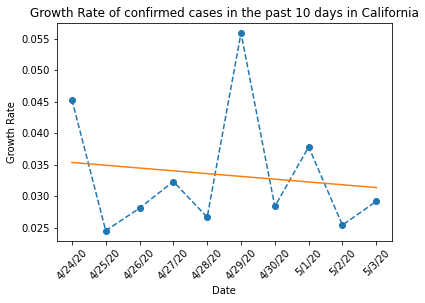

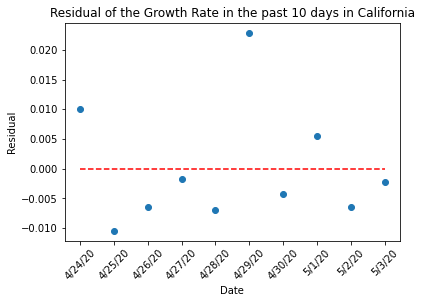

The peak time will come on 2020-07-12


In [81]:
fit_linear_model("California", 10)

In the following cell, try fitting a linear regression model of the growth rate in California in the past 30 days counting down from 5/3/20.

                            OLS Regression Results                            
Dep. Variable:            Growth Rate   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     17.24
Date:                Sat, 09 May 2020   Prob (F-statistic):           0.000279
Time:                        01:46:07   Log-Likelihood:                 71.882
No. Observations:                  30   AIC:                            -139.8
Df Residuals:                      28   BIC:                            -137.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0813      0.008     10.007      0.0

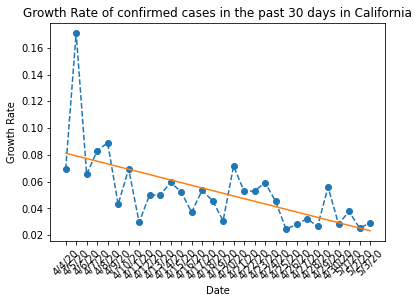

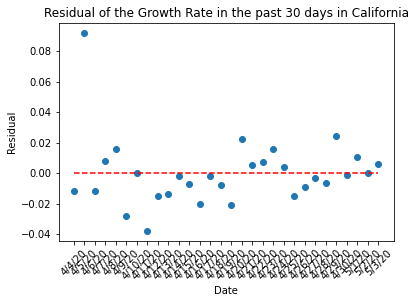

The peak time will come on 2020-05-14


In [82]:
fit_linear_model("California", 30)

In the following cells, do the similar analysis in the state of New York as in California.

                            OLS Regression Results                            
Dep. Variable:            Growth Rate   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.194
Method:                 Least Squares   F-statistic:                   0.02315
Date:                Sat, 09 May 2020   Prob (F-statistic):              0.885
Time:                        01:46:08   Log-Likelihood:                 33.836
No. Observations:                   7   AIC:                            -63.67
Df Residuals:                       5   BIC:                            -63.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0137      0.002      8.831      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning:

omni_normtest is not valid with less than 8 observations; 7 samples were given.



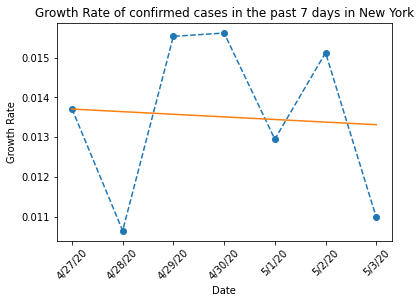

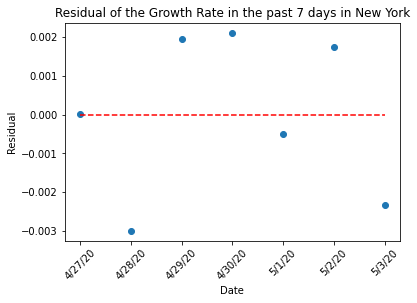

The peak time will come on 2020-11-22


In [83]:
fit_linear_model("New York", 7)

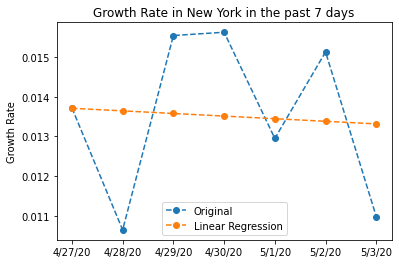

The cross-validation scores are:  [1. 1. 1.]


In [84]:
fit_evaluate("New York", 7)

                            OLS Regression Results                            
Dep. Variable:            Growth Rate   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                 -0.096
Method:                 Least Squares   F-statistic:                    0.4763
Date:                Sat, 09 May 2020   Prob (F-statistic):              0.521
Time:                        01:46:09   Log-Likelihood:                 34.738
No. Observations:                   7   AIC:                            -65.48
Df Residuals:                       5   BIC:                            -65.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0209      0.001     15.350      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning:

omni_normtest is not valid with less than 8 observations; 7 samples were given.



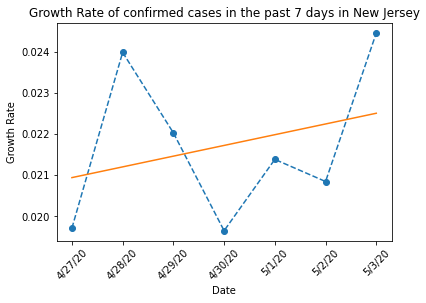

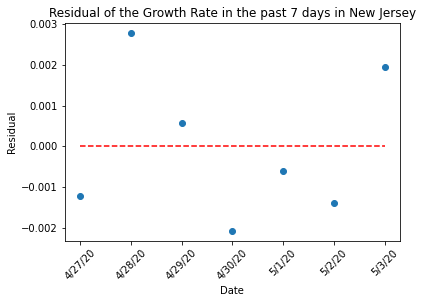

The growth rate is still increasing


In [85]:
fit_linear_model("New Jersey", 7)

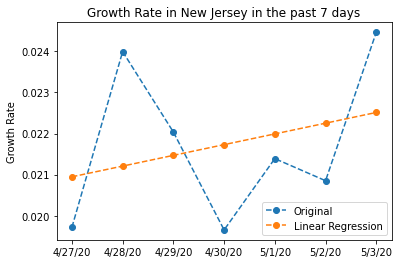

The cross-validation scores are:  [1. 1. 1.]


In [86]:
fit_evaluate("New Jersey", 7)

## **Q2: How has social distancing affected covid19 rate?**

First, we will sort the states by the average date that they began implementing social distancing measures.

In [0]:
states_stay_at_home = abridged_counties[['CountyName','State','stay at home']].groupby('State').mean()
states_stay_at_home = states_stay_at_home.sort_values(by='stay at home')
states_stay_at_home = states_stay_at_home.dropna()

In [88]:
earliest_states = states_stay_at_home.head(5)
earliest_states

,stay at home
State,
California,737503.0
Illinois,737505.0
New Jersey,737505.0
New York,737506.0
Washington,737507.0


In [89]:
latest_states = states_stay_at_home.tail(5)
latest_states

,stay at home
State,
Georgia,737517.792453
Alabama,737518.865672
Missouri,737519.782609
Mississippi,737520.743902
South Carolina,737522.000000


Next we sum the confirmed rates by state and add a population column.

In [90]:
confirmed_by_state = confirmed.groupby('Province_State').sum().drop(columns=['UID','code3','FIPS','Lat','Long_'])
confirmed_by_state = pd.merge(states_stay_at_home,confirmed_by_state,left_index=True, right_index=True)
states_pop = deaths.groupby('Province_State').sum()[['Population']] #series containing population of each state
confirmed_by_state = pd.merge(states_pop,confirmed_by_state,left_index=True, right_index=True)
confirmed_by_state = confirmed_by_state.sort_values(by='stay at home')
confirmed_by_state.head(3)

,Population,stay at home,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20
California,39512223,737503.0,0,0,0,0,2,2,2,2,2,3,3,3,6,6,6,6,6,6,6,6,7,7,8,8,8,8,8,8,8,8,10,10,10,10,10,10,11,11,...,2998,3899,4657,5095,5852,7138,8210,9399,10773,12004,12837,15034,16019,17351,18897,19710,21081,21706,22795,23931,25356,26686,27677,29157,30491,31431,33686,35465,37344,39561,41355,42368,43558,44966,46164,48747,50130,52026,53347,54903
Illinois,12671821,737505.0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,1865,2538,3024,3491,4596,5056,5994,6980,7695,8904,10357,11259,12262,13553,15078,16422,17887,19180,20852,22025,23248,24593,25734,27578,29160,30357,31513,33059,35107,36937,39658,41777,43903,45883,48102,50358,52918,56055,58505,61499
New Jersey,8882190,737505.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4402,6876,8825,11124,13386,16636,18696,22255,25590,29895,34124,37505,41090,44416,47437,51027,54588,58151,61850,64584,68824,71030,75317,78467,81420,85301,88722,92387,95914,100025,102196,105498,109038,111188,113856,116365,118652,121190,123717,126744


Let's also convert the stay at home date to a more readable format.

In [91]:
confirmed_by_state['stay at home'] = confirmed_by_state['stay at home'].astype(int).apply(pd.Timestamp.fromordinal)
confirmed_by_state.head(3)

,Population,stay at home,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20
California,39512223,2020-03-19,0,0,0,0,2,2,2,2,2,3,3,3,6,6,6,6,6,6,6,6,7,7,8,8,8,8,8,8,8,8,10,10,10,10,10,10,11,11,...,2998,3899,4657,5095,5852,7138,8210,9399,10773,12004,12837,15034,16019,17351,18897,19710,21081,21706,22795,23931,25356,26686,27677,29157,30491,31431,33686,35465,37344,39561,41355,42368,43558,44966,46164,48747,50130,52026,53347,54903
Illinois,12671821,2020-03-21,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,1865,2538,3024,3491,4596,5056,5994,6980,7695,8904,10357,11259,12262,13553,15078,16422,17887,19180,20852,22025,23248,24593,25734,27578,29160,30357,31513,33059,35107,36937,39658,41777,43903,45883,48102,50358,52918,56055,58505,61499
New Jersey,8882190,2020-03-21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4402,6876,8825,11124,13386,16636,18696,22255,25590,29895,34124,37505,41090,44416,47437,51027,54588,58151,61850,64584,68824,71030,75317,78467,81420,85301,88722,92387,95914,100025,102196,105498,109038,111188,113856,116365,118652,121190,123717,126744


We then divide the confirmed cases per day by the total population of the state, to normalize the number of cases.

In [92]:
confirmed_by_state_dates = confirmed_by_state.loc[:,'1/22/20':].div(confirmed_by_state['Population'],axis=0)
confirmed_by_state_dates.head(3)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20
California,0.0,0.0,0.000000e+00,0.000000e+00,5.061725e-08,5.061725e-08,5.061725e-08,5.061725e-08,5.061725e-08,7.592587e-08,7.592587e-08,7.592587e-08,1.518517e-07,1.518517e-07,1.518517e-07,1.518517e-07,1.518517e-07,1.518517e-07,1.518517e-07,1.518517e-07,1.771604e-07,1.771604e-07,2.024690e-07,2.024690e-07,2.024690e-07,2.024690e-07,2.024690e-07,2.024690e-07,2.024690e-07,2.024690e-07,2.530862e-07,2.530862e-07,2.530862e-07,2.530862e-07,2.530862e-07,2.530862e-07,2.783949e-07,2.783949e-07,3.037035e-07,3.037035e-07,...,0.000076,0.000099,0.000118,0.000129,0.000148,0.000181,0.000208,0.000238,0.000273,0.000304,0.000325,0.000380,0.000405,0.000439,0.000478,0.000499,0.000534,0.000549,0.000577,0.000606,0.000642,0.000675,0.000700,0.000738,0.000772,0.000795,0.000853,0.000898,0.000945,0.001001,0.001047,0.001072,0.001102,0.001138,0.001168,0.001234,0.001269,0.001317,0.001350,0.001390
Illinois,0.0,0.0,7.891526e-08,7.891526e-08,7.891526e-08,7.891526e-08,7.891526e-08,7.891526e-08,7.891526e-08,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,1.578305e-07,2.367458e-07,...,0.000147,0.000200,0.000239,0.000275,0.000363,0.000399,0.000473,0.000551,0.000607,0.000703,0.000817,0.000889,0.000968,0.001070,0.001190,0.001296,0.001412,0.001514,0.001646,0.001738,0.001835,0.001941,0.002031,0.002176,0.002301,0.002396,0.002487,0.002609,0.002770,0.002915,0.003130,0.003297,0.003465,0.003621,0.003796,0.003974,0.004176,0.004424,0.004617,0.004853
New Jersey,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000496,0.000774,0.000994,0.001252,0.001507,0.001873,0.002105,0.002506,0.002881,0.003366,0.003842,0.004222,0.004626,0.005001,0.005341,0.005745,0.006146,0.006547,0.006963,0.007271,0.007749,0.007997,0.008480,0.008834,0.009167,0.009604,0.009989,0.010401,0.010798,0.011261,0.011506,0.011877,0.012276,0.012518,0.012818,0.013101,0.013358,0.013644,0.013929,0.014269


Let's see what the graphs of the earliest social distancing states look like.

Text(0.5, 1.0, 'Confirmed COVID-19 Cases')

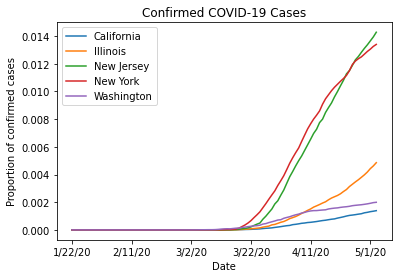

In [93]:
confirmed_by_state_dates.loc[list(earliest_states.index.values)].T.plot()
plt.xlabel('Date')
plt.ylabel('Proportion of confirmed cases')
plt.title('Confirmed COVID-19 Cases')

And now the latest social distancing states:

Text(0.5, 1.0, 'Confirmed COVID-19 Cases')

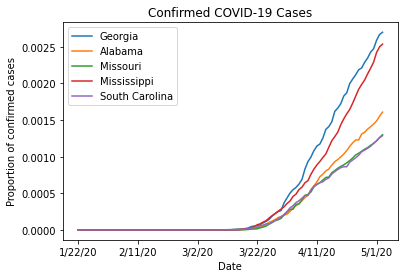

In [94]:
confirmed_by_state_dates.loc[list(latest_states.index.values)].T.plot()
plt.xlabel('Date')
plt.ylabel('Proportion of confirmed cases')
plt.title('Confirmed COVID-19 Cases')

Both earlier and later states seem to have an upward trend, so it is hard to tell if social distancing has made a difference from just the confirmed rates graph.

Let's find out how long it took for states to begin social distancing after their first cases. First we create a column that keeps track of the date that states first started getting Covid-19 cases.

In [95]:
cols = list(confirmed_by_state)[2:]
first_cases = pd.Series()
for index, row in confirmed_by_state.iterrows():
    for col in cols:
      if row[col] > 100:
        first_cases[index] = col
        break
confirmed_by_state['first_cases'] = pd.to_datetime(first_cases)
confirmed_by_state.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



,Population,stay at home,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,...,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,first_cases
California,39512223,2020-03-19,0,0,0,0,2,2,2,2,2,3,3,3,6,6,6,6,6,6,6,6,7,7,8,8,8,8,8,8,8,8,10,10,10,10,10,10,11,11,...,3899,4657,5095,5852,7138,8210,9399,10773,12004,12837,15034,16019,17351,18897,19710,21081,21706,22795,23931,25356,26686,27677,29157,30491,31431,33686,35465,37344,39561,41355,42368,43558,44966,46164,48747,50130,52026,53347,54903,2020-03-09
Illinois,12671821,2020-03-21,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,2538,3024,3491,4596,5056,5994,6980,7695,8904,10357,11259,12262,13553,15078,16422,17887,19180,20852,22025,23248,24593,25734,27578,29160,30357,31513,33059,35107,36937,39658,41777,43903,45883,48102,50358,52918,56055,58505,61499,2020-03-17
New Jersey,8882190,2020-03-21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6876,8825,11124,13386,16636,18696,22255,25590,29895,34124,37505,41090,44416,47437,51027,54588,58151,61850,64584,68824,71030,75317,78467,81420,85301,88722,92387,95914,100025,102196,105498,109038,111188,113856,116365,118652,121190,123717,126744,2020-03-16


Subtract the stay at home date from the first case date to get how long it took for states to begin social distancing.

In [96]:
confirmed_by_state['socdist_delay'] = confirmed_by_state['stay at home'] - confirmed_by_state['first_cases']
confirmed_by_state = confirmed_by_state.sort_values('socdist_delay')
confirmed_by_state.tail(3)

,Population,stay at home,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,first_cases,socdist_delay
Florida,21477737,2020-04-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2900,3763,4246,5473,6741,6956,9008,10268,11537,12350,13324,14545,15456,16364,17531,18494,19895,21019,21628,22511,23343,24759,25492,26314,27059,27869,28309,29648,30533,30839,31532,32138,32848,33193,33690,34728,35463,36078,2020-03-16,16 days
Georgia,10617423,2020-04-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2000,2366,2651,2808,3929,4638,5348,5831,6160,6647,7314,8822,9901,10566,11485,12159,12452,13315,14578,14987,15669,17194,17669,18301,19407,19881,21214,21883,22491,23222,23486,24302,24922,25775,26264,27489,28331,28665,2020-03-16,17 days
South Carolina,5148714,2020-04-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,542,660,774,925,1083,1293,1554,1700,1917,2049,2232,2417,2417,2793,3067,3211,3320,3391,3553,3656,3931,4099,4248,4377,4446,4439,4761,4917,5070,5253,5498,5613,5735,5882,6095,6258,6489,6626,2020-03-20,18 days


Add a column representing total number of cases normalized by state population.

In [0]:
confirmed_by_state['normalized_cases'] = confirmed_by_state['5/3/20']#/confirmed_by_state['Population']

Text(0.5, 1.0, 'Social Distancing vs. COVID-19 Cases')

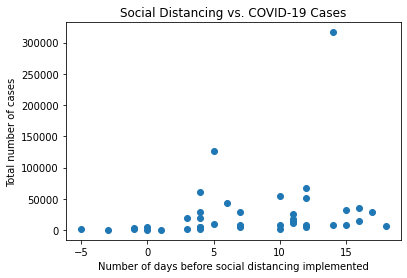

In [98]:
plt.scatter(confirmed_by_state['socdist_delay'].dt.days,confirmed_by_state['normalized_cases'])
plt.xlabel('Number of days before social distancing implemented')
plt.ylabel('Total number of cases')
plt.title('Social Distancing vs. COVID-19 Cases')

There is minimal correlation between when social distancing was implemented and the current number of cases.

Let's try to see what the growth rate of cases is prior to and after social distancing for California.

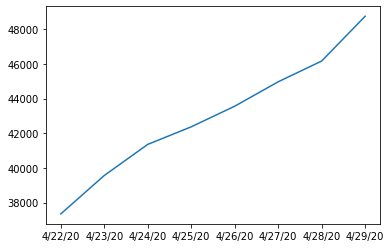

In [99]:
before_sd = confirmed_by_state.loc['California']['3/12/20':'3/19/20']
after_sd = confirmed_by_state.loc['California']['4/22/20':'4/29/20']
plt.plot(after_sd)

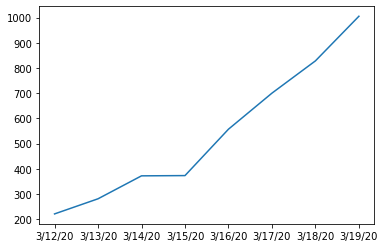

In [100]:
plt.plot(before_sd)

## **Q3: What are some factors that are correlated with the mortality rate?**

Find the top 20 states with the highest mortality rate 

Province_State    0
Mortality_Rate    1
Country_Region    0
dtype: int64

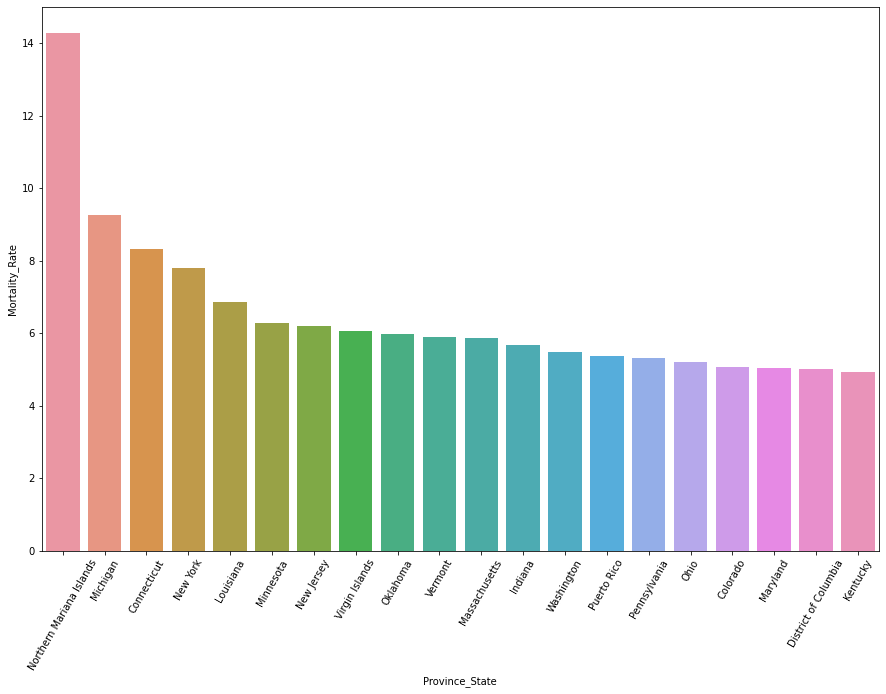

In [101]:
# create a DataFrame from states with only the states and mortality rate columns 
states_mortality = states[["Province_State", "Mortality_Rate", "Country_Region"]]
# select only entries in the US 
states_mortality = states_mortality[states_mortality["Country_Region"] == "US"]
# look to see if there are any missing values 
display(states_mortality.isnull().sum())
# discard the rows with missing values
states_mortality = states_mortality.dropna(axis = 0)
# sort the Mortality_Rate column in descending order and get the top 20
states_mortality = states_mortality.sort_values(by = "Mortality_Rate", ascending = False).iloc[:20, :]
# making a bar plot of the 20 states 
plt.figure(figsize = (15, 10))
ax = sns.barplot(data = states_mortality, x = "Province_State", y = "Mortality_Rate")
for item in ax.get_xticklabels():
    item.set_rotation(60)

Is there a correlation between those three rates in the states DataFrame? Try generating the correlation matrix to see all the correlations between the covariates

In [102]:
# create a DataFrame from states with only the states and mortality rate columns 
states_rate = states[["Province_State", "Mortality_Rate", "Country_Region", "Incident_Rate", "Hospitalization_Rate", "Testing_Rate"]]
# select only entries in the US 
states_rate = states_rate[states_rate["Country_Region"] == "US"]
# discard the rows with missing values
states_rate = states_rate.dropna(axis = 0)
states_rate[["Incident_Rate", "Hospitalization_Rate", "Testing_Rate", "Mortality_Rate"]].corr()

,Incident_Rate,Hospitalization_Rate,Testing_Rate,Mortality_Rate
Incident_Rate,1.000000,0.160188,0.665500,0.511207
Hospitalization_Rate,0.160188,1.000000,-0.304560,0.733855
Testing_Rate,0.665500,-0.304560,1.000000,-0.000423
Mortality_Rate,0.511207,0.733855,-0.000423,1.000000


From the above, we see that both Incident_Rate and Hospitalization_Rate have a relatively high correlation with Mortality_Rate, which makes sense because people who are hospitalized might have already developed a higher level of seriousness in the coronavirus so there might be a correlation between hospitalization rate and mortality rate. 

In the following cell, we use the "abridged_couty" data set, and focus on the risk factors to see whether there is a correlation between any of these risk factors and mortality rate. To deal with null values, we simply drop the rows and we take the average of the risk factors to get to a state level so that we can join the dataframe with "states" later.

In [103]:
# take the abridged_county DataFrame, group by the states and take the average of health factors 
# first take only the health-risk factor columns 
columns = ["State", "HeartDiseaseMortality", "StrokeMortality", "Smokers_Percentage", "RespMortalityRate2014"]
abridged_counties_cleaned =  abridged_counties.loc[:, columns]
# check if there are missing values 
display(abridged_counties_cleaned.isnull().sum())
# discard all rows with missing values 
abridged_counties_cleaned = abridged_counties_cleaned.dropna(axis = 0)
# group by State and take the average 
abridged_counties_cleaned = abridged_counties_cleaned.groupby(by = "State").agg(np.average)
# merge with states DataFrame 
merged = abridged_counties_cleaned.merge(states, left_on = "State", right_on = "Province_State")
# the shape of the DataFrame 
display(merged.shape)
# display the head 
merged.head()

State                    169
HeartDiseaseMortality     42
StrokeMortality           34
Smokers_Percentage       103
RespMortalityRate2014    103
dtype: int64

(48, 22)

,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,243.595522,51.450746,19.989231,77.282985,Alabama,US,2020-05-04 02:32:32,32.3182,-86.9023,7888,290,0,7598.0,1,168.227197,92500.0,1035.0,3.676471,84000001,USA,1972.745403,13.121197
1,148.826667,30.900000,16.483911,51.968667,Arizona,US,2020-05-04 02:32:32,33.7298,-111.4312,8640,362,1597,6681.0,4,118.702238,81119.0,1348.0,4.189815,84000004,USA,1114.468388,15.601852
2,235.172000,47.681333,20.388849,72.727067,Arkansas,US,2020-05-04 02:32:32,34.9697,-92.3731,3437,76,1999,1362.0,5,132.752575,52890.0,427.0,2.211231,84000005,USA,2042.852392,12.423625
3,153.908621,37.891379,12.091600,52.153621,California,US,2020-05-04 02:32:32,36.1162,-119.6816,54903,2216,0,52687.0,6,140.027882,715751.0,NaN,4.036209,84000006,USA,1825.493986,NaN
4,130.337500,32.851562,14.297498,61.043125,Colorado,US,2020-05-04 02:32:32,39.0598,-105.3111,16635,842,2607,13186.0,8,293.551243,79906.0,2793.0,5.061617,84000008,USA,1410.069469,16.789901


In [104]:
# select columns 
columns = ["Province_State", "HeartDiseaseMortality", "StrokeMortality", "Smokers_Percentage", "RespMortalityRate2014", "Mortality_Rate"]
# create a DataFrame with only these columns 
merged_columns = merged[columns]
# display the correlation matrix 
display(merged_columns.iloc[:, 1:].corr())


,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,Mortality_Rate
HeartDiseaseMortality,1.000000,0.801569,0.765037,0.722060,0.063791
StrokeMortality,0.801569,1.000000,0.673217,0.671670,-0.147894
Smokers_Percentage,0.765037,0.673217,1.000000,0.788338,0.000063
RespMortalityRate2014,0.722060,0.671670,0.788338,1.000000,-0.105098
Mortality_Rate,0.063791,-0.147894,0.000063,-0.105098,1.000000


From the above we see that the risk factors have pretty high association with each other, there seems to be a strong multilinearity among these covariates. However, interestinly the correlation between any of the risk factors and Mortality_Rate is pretty low, which might due to the fact that we averaged the data into a state level and during that process we might have lost some important information.

## **Q4: how is the trend of total confirmed cases in California changing overtime?**

In the following cell, we wrote funtions to make plots of the total confirmed cases in the state of California and also the cases in log scale. 

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning:

divide by zero encountered in log



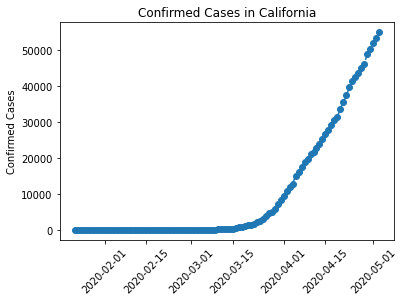

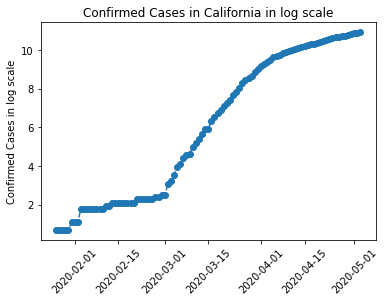

In [105]:
# the overall data so far in california 
california = get_df("California", 103)
plt.plot(pd.to_datetime(california.index), california["Cases"], linestyle = '--', marker = 'o')
plt.xticks(rotation = 45)
plt.ylabel("Confirmed Cases")
plt.title("Confirmed Cases in California")
plt.show()
# make the log plot underneath 
plt.plot(pd.to_datetime(california.index), california["log"], linestyle = '--', marker = 'o')
plt.ylabel("Confirmed Cases in log scale")
plt.title("Confirmed Cases in California in log scale")
plt.xticks(rotation = 45)
plt.show()

From the log scale we see that there is a clear "jump" near the date of 3/1/20 which "separates" the trend in two pieces. According to the article "https://www.latimes.com/projects/california-coronavirus-cases-tracking-outbreak/" we found that it is because the state increased testing on 3/1/20 which contributes to a jump in total cases. In the following cell, we separate the data into two pieces, one before 3/1 and one from 3/1/20 to 5/3/20.

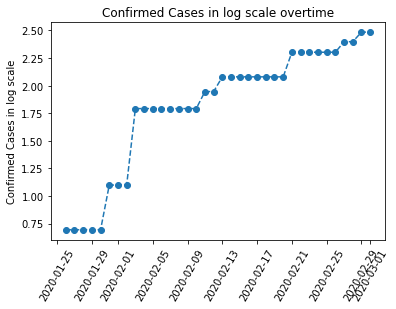

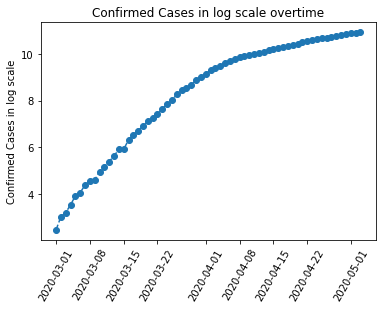

In [106]:
# get a slice of california and make the plot of its log 
cal_before = get_slice(california, "2020-01-22", "2020-03-01")
plt.plot(pd.to_datetime(cal_before.index),
         cal_before["log"], 
         linestyle = '--', 
         marker = 'o')
plt.xticks(rotation = 60)
plt.ylabel("Confirmed Cases in log scale")
plt.title("Confirmed Cases in log scale overtime")
plt.show()
cal_after = get_slice(california, "2020-03-01", "2020-05-03")
plt.plot(pd.to_datetime(cal_after.index),
         cal_after["log"],
         linestyle = '--', 
         marker = 'o')
plt.xticks(rotation = 60)
plt.ylabel("Confirmed Cases in log scale")
plt.title("Confirmed Cases in log scale overtime")
plt.show()

By separating the data into two pieces, we see that from 3/1 the log scale of total confirmed cases behaves in a log trend and flattens out in the end, which suggests that if we were to fit a model, a log model might be a good choice. 